Create compression version of GPT-2 nad BERT model and save the memory =)

## cola example

The Semantic Textual Similarity Benchmark (Cer et al., 2017) is a collection of sentence pairs drawn from news headlines, video and image captions, and natural language inference data. Each pair is human-annotated with a similarity score from 0 to 5.

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"


In [2]:
#!pip install Partial State

In [3]:
import transformers
print (transformers.__version__)

4.30.2


In [4]:
from sparse_grad import replace_bert_layers

In [5]:
def create_space_matrices(model):
    if hasattr(model, "bert") and hasattr(model.bert, "encoder"):
        encoder = model.bert.encoder
    elif hasattr(model, "encoder"):
        encoder = model.encoder
    else:
        raise ValueError("Expected model to have attribute 'encoder' or 'bert.encoder'.")

    for i, layer in enumerate(encoder.layer):
        
        layer.intermediate.dense.create_UV()
          
        layer.output.dense.create_UV()
          
        #print ("new shape", layer.output.dense.weight.shape)
        #print ("\n\n")

    return model

In [6]:
def sparse_grad_linear(model, *args):
    print ("create bert with sparse grads")
    model = replace_bert_layers(model)
    print ("created bert with sparse grads")
    return model

In [7]:
from datasets import load_dataset
import pandas as pd

dataset_cola_cut = load_dataset('glue', 'cola', split='train[:10%]')
dataset_cola_cut.num_rows

Found cached dataset glue (/root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


855

In [8]:
dataset_cola_cut

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 855
})

In [9]:
dataset_cola = load_dataset('glue', 'cola')
dataset_cola.num_rows

Found cached dataset glue (/root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': 8551, 'validation': 1043, 'test': 1063}

In [10]:
label_list = dataset_cola["train"].features["label"].names
num_labels = len(label_list)


In [11]:
config

Available objects for config:
     AliasManager
     DisplayFormatter
     HistoryManager
     IPCompleter
     IPKernelApp
     InlineBackend
     LoggingMagics
     MagicsManager
     OSMagics
     PrefilterManager
     ScriptMagics
     StoreMagics
     ZMQInteractiveShell


In [12]:
set(pd.DataFrame(dataset_cola['train']).label)

{0, 1}

In [13]:
task_num_labels = num_labels

from transformers import AutoConfig, BertConfig, AutoModelForSequenceClassification, AutoTokenizer

path_name = r"bert-base-uncased"

config = AutoConfig.from_pretrained(
    path_name,
    num_labels=num_labels,
)

model = AutoModelForSequenceClassification.from_pretrained(
    path_name,
    config=config,
)

tokenizer = AutoTokenizer.from_pretrained(path_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [14]:
#model=model.to('cuda:2')

In [15]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
sentence1_key, sentence2_key = task_to_keys['cola']

In [16]:

def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
        )
        
        
        result = tokenizer.batch_encode_plus(*args, max_length=128, truncation=True, padding="max_length")

        result["label"] = examples["label"]
        return result

In [17]:
num_labels

2

In [18]:
dataset_cola['train']

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 8551
})

In [19]:
tokenized_dataset_cut = dataset_cola_cut.map(
            preprocess_function,
            batched=True,
            load_from_cache_file=False
        )

  0%|          | 0/1 [00:00<?, ?ba/s]

In [20]:
tokenized_dataset = dataset_cola.map(
            preprocess_function,
            batched=True,
            load_from_cache_file=False
        )

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [21]:
tokenized_dataset['validation']

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1043
})

In [22]:
tokenized_dataset_cut

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 855
})

In [23]:
from torch.utils.data import DataLoader, RandomSampler

eval_dataloader = DataLoader(tokenized_dataset['validation'], batch_size=10)


In [24]:
type(tokenized_dataset)

datasets.dataset_dict.DatasetDict

In [25]:
from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

2023-07-10 21:13:24.690830: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [26]:
metric = ev.load("glue", 'cola')

In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
def compute_metrics(p: EvalPrediction):
        preds_ = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds_ = np.argmax(preds_, axis=1)
        
        result = metric.compute(predictions=preds_, references=p.label_ids)
        if True:
            result["combined_score"] = np.mean(list(result.values())).item()
            return result
        else:
            return {"accuracy": (preds_ == p.label_ids).astype(np.float32).mean().item()}

In [29]:
training_args = TrainingArguments(
    learning_rate=2e-5,
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=100,
    eval_steps=100,
    output_dir="./bert_stsb_128",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

In [30]:
class TrainerBert(Trainer):
    
    def make_grad_bank(self):
        self.n_show = 10
        self.losses = []
    
    def training_step(self, model, inputs):
        model.train()
        inputs = self._prepare_inputs(inputs)
        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)
        loss.backward()
        for layer in range(12):
                
            if (len(model.bert.encoder.layer[layer].output.dense.grads)) < -1:
                model.bert.encoder.layer[layer].output.dense.grads.append(model.bert.encoder.layer[layer].output.dense.weight.grad)

            if (len(model.bert.encoder.layer[layer].intermediate.dense.grads)) < -1:
                model.bert.encoder.layer[layer].intermediate.dense.grads.append(model.bert.encoder.layer[layer].intermediate.dense.weight.grad)

            else:
                if (self.n_show > 0):
                    self.n_show -= 1
                    im= plt.imshow(model.bert.encoder.layer[layer].output.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    plt.title('grad '+'20x20 ' + str(self.n_show)) 
                    plt.colorbar(im) #not in spy
                    plt.show()

                    im= plt.imshow(model.bert.encoder.layer[layer].intermediate.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    plt.title('grad '+'20x20 ' + str(self.n_show)) 
                    plt.colorbar(im) #not in spy
                    plt.show()
                
                    
        
        

        self.losses.append(loss.cpu().detach().numpy())
        return loss.detach()

In [31]:
model = sparse_grad_linear(model)

create bert with sparse grads
created bert with sparse grads


In [32]:
trainer = TrainerBert(
        model=model,
        args=training_args,
        #train_dataset=tokenized_dataset["train"],
        train_dataset = tokenized_dataset_cut,
        eval_dataset=tokenized_dataset["validation"],
)
trainer.make_grad_bank()

In [33]:
trainer.train_dataset

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 855
})

In [34]:
U = trainer.model.bert.encoder.layer[1].output.dense.U

In [35]:
U

len small dataset 855
lets collect gradients


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


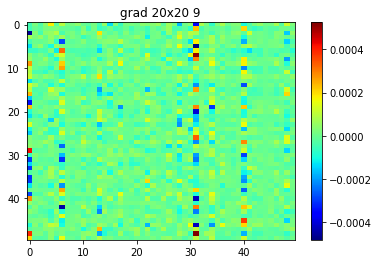

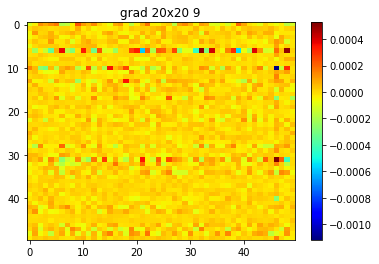

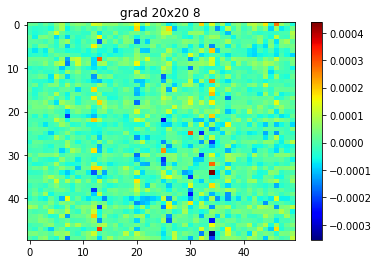

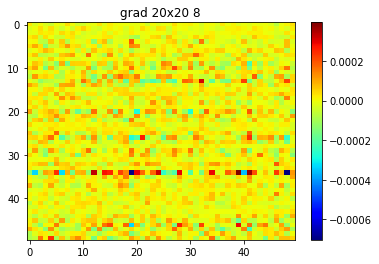

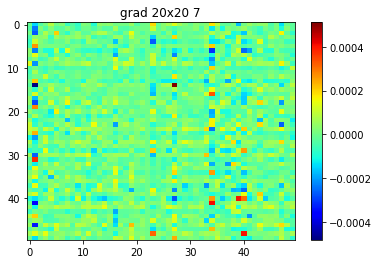

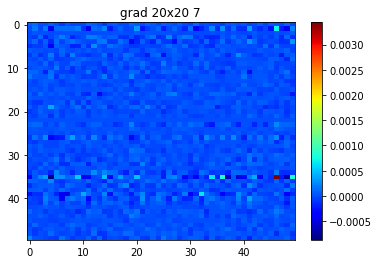

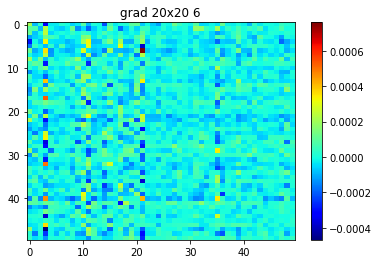

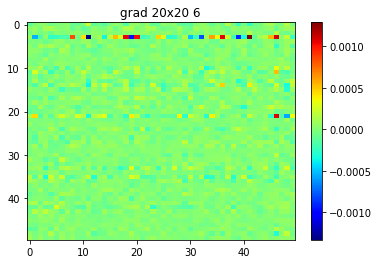

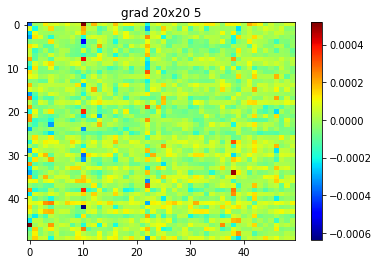

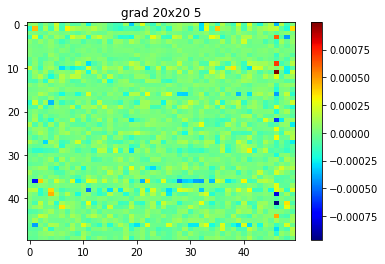

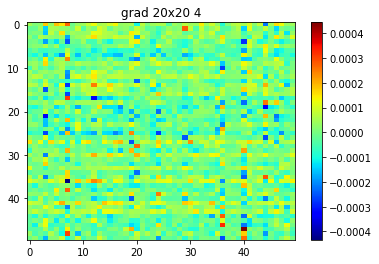

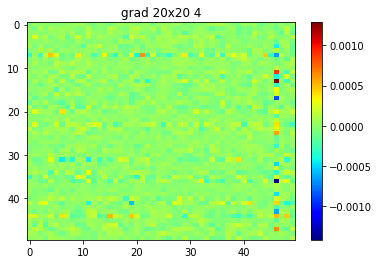

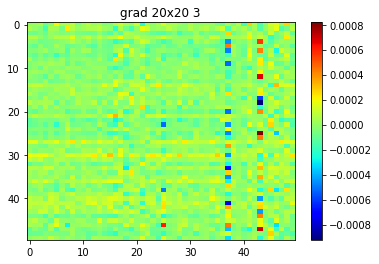

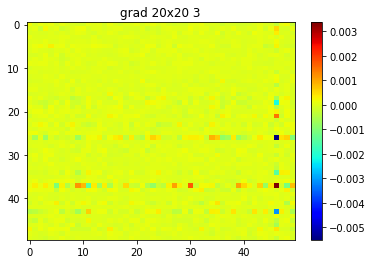

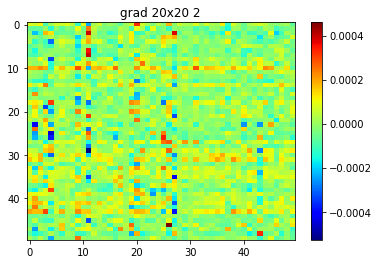

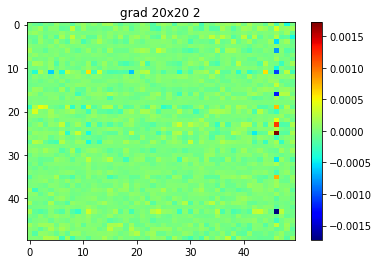

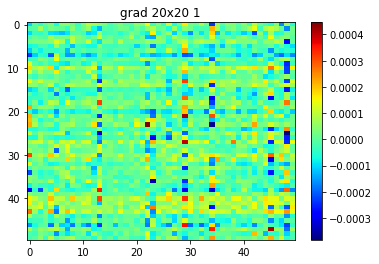

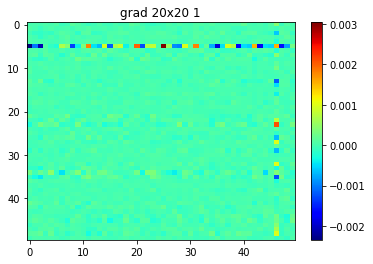

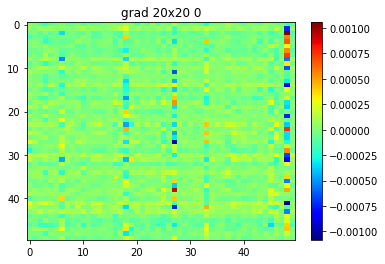

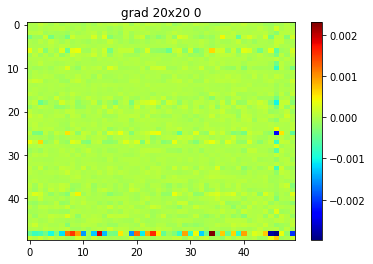

Step,Training Loss
500,0.213200


finishing collecting gradients


In [36]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

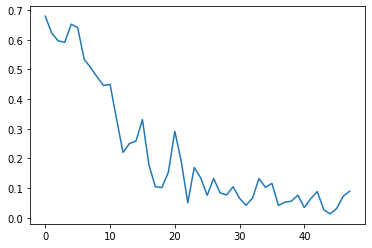

In [37]:
plt.plot(np.mean(np.array(trainer.losses[:480]).reshape(-1, 10), axis=1))

In [38]:
import pickle

with open('no_trh.pickle', 'wb') as handle:
    pickle.dump(np.mean(np.array(trainer.losses[:480]).reshape(-1, 10), axis=1), handle, protocol=pickle.HIGHEST_PROTOCOL)

## Regular bert

In [88]:
model = AutoModelForSequenceClassification.from_pretrained(
    path_name,
    config=config,
)

tokenizer = AutoTokenizer.from_pretrained(path_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [89]:
training_args = TrainingArguments(
    learning_rate=2e-5,
    num_train_epochs=9,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=100,
    eval_steps=100,
    output_dir="./bert_stsb_128",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

In [90]:
trainer = Trainer(
        model=model,
        args=training_args,
        #train_dataset=tokenized_dataset["train"],
        train_dataset = tokenized_dataset_cut,
        eval_dataset=tokenized_dataset["validation"],
)

In [91]:
trainer.train()

/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=486, training_loss=0.23820762477293916, metrics={'train_runtime': 50.019, 'train_samples_per_second': 153.842, 'train_steps_per_second': 9.716, 'total_flos': 506159892748800.0, 'train_loss': 0.23820762477293916, 'epoch': 9.0})

In [49]:
trainer.evaluate()

{'eval_loss': 1.072302222251892,
 'eval_runtime': 1.206,
 'eval_samples_per_second': 864.836,
 'eval_steps_per_second': 7.463,
 'epoch': 9.0}